<a href="https://colab.research.google.com/github/Timmmtech/Pytorch-Basics/blob/main/Training_deep_neural_network_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
# Download the data and create a Pytorch dataset
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)

image_permuted = image.permute(1,2,0)
image_permuted.shape

image.shape: torch.Size([1, 28, 28])


torch.Size([28, 28, 1])

Label: 5


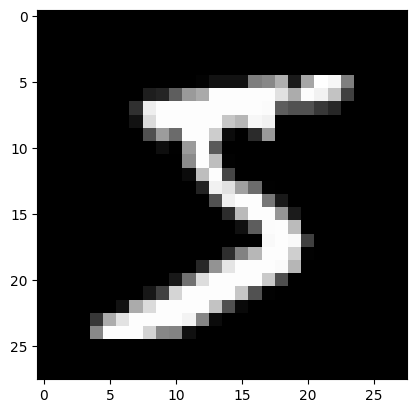

In [4]:
plt.imshow(image[0], cmap='gray')
print('Label:' ,label)

In [5]:
## separate train set from validation set
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
## Create Pytorch data loaders for training and validation
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


images.shape: torch.Size([128, 1, 28, 28])


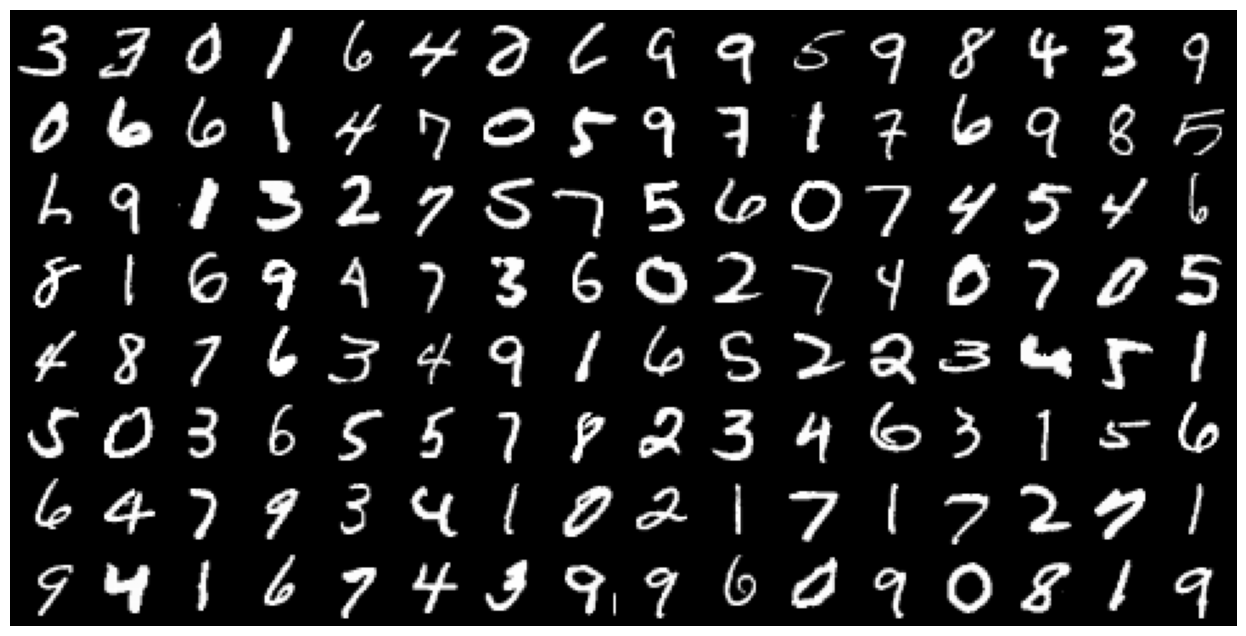

In [8]:
## Visualize a batch of data
for images, _ in train_loader:
  print('images.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
  break

### Hidden Layers, Activation Fucntions and Non-Linearity

In [9]:
## Flatten out the 1x28x28 images into 784 vector size for nn.Linear
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
## Create nn.Linear object that will serve as the hidden layer
## The size of the hidden layer output will be 32, it can be increased or decreased to change learning capacity of the model
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape


torch.Size([128, 784])

In [13]:
## Compute intermediate output for the batch of images
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [14]:
## Apply activation function to layer1_outputs and verify negative were replaced with 0
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7046881914138794
min(relu_outputs): 0.0


In [15]:
## Create output layer to convert vectors of length hidden_size in relu_outputs
# into vectors of length 10, i.e desired output since there're 10 targets lebels
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [16]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [17]:
inputs.shape

torch.Size([128, 784])

In [18]:
## use the output to compute the loss
F.cross_entropy(layer2_outputs, labels)

tensor(2.3146, grad_fn=<NllLossBackward0>)

In [19]:
## Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [20]:
## verify
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [21]:
## Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [22]:
## Create a single layer to replace the two layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [23]:
## same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [24]:
torch.allclose(outputs2, outputs3, 1e-3)

True

### Model
 We will define our model by extending the nn.Module class from pytorch

In [25]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""

    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)  # flatten 28x28 images
        out = self.linear1(xb)
        out = torch.relu(out)
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()

        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()

        return {
            'val_loss': epoch_loss.item(),
            'val_acc': epoch_acc.item()
        }

    def epoch_end(self, epoch, result):
        print(
            f"Epoch [{epoch}], "
            f"val_loss: {result['val_loss']:.4f}, "
            f"val_acc: {result['val_acc']:.4f}"
        )

In [26]:
## def accuracy function
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [27]:
## create model with hidden layer with 32 activations
input_size = 784
hidden_size = 32
num_classes = 10

In [28]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [29]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [30]:
## Generate output with the model
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape:', outputs.shape)
print('Sample outputs :/n', outputs[:2].data)

Loss: 2.2999725341796875
outputs.shape: torch.Size([128, 10])
Sample outputs :/n tensor([[ 0.0919, -0.0413,  0.1129, -0.2385, -0.0180, -0.0283, -0.1166, -0.0075,
         -0.0926, -0.0493],
        [ 0.1425,  0.0109,  0.0339, -0.1803, -0.0699, -0.1448, -0.0973,  0.0510,
         -0.1863,  0.0073]])


### Using GPU

In [31]:
torch.cuda.is_available()

True

In [32]:
from torch.cuda import is_available
## Helper function for GPU
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [33]:
device = get_default_device()
device

device(type='cuda')

In [34]:
## Define a function that can move data and model to a chosen device
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [35]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [36]:
## define a DeviceDataLoader to wrap existing dataloader and move batches of data to selected device
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [37]:
## wrap dataloader using DeviceDataLoader
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [38]:
for xb, yb in val_loader:
  print('xb.device:', xb.device)
  print('yb:', yb)
  break

xb.device: cuda:0
yb: tensor([4, 7, 0, 4, 9, 2, 4, 2, 8, 4, 8, 2, 5, 8, 2, 0, 0, 9, 9, 2, 0, 4, 3, 3,
        6, 6, 8, 1, 3, 7, 6, 4, 4, 2, 2, 8, 9, 5, 8, 4, 0, 6, 4, 0, 8, 7, 4, 2,
        1, 2, 3, 9, 6, 2, 0, 1, 6, 5, 0, 2, 8, 1, 7, 3, 7, 6, 4, 0, 0, 4, 6, 7,
        1, 3, 9, 5, 3, 3, 2, 2, 8, 7, 0, 7, 6, 6, 2, 0, 4, 6, 6, 6, 3, 2, 8, 2,
        7, 3, 8, 6, 3, 4, 4, 5, 9, 2, 2, 4, 9, 3, 7, 3, 8, 0, 7, 8, 6, 1, 3, 5,
        3, 1, 9, 5, 9, 2, 3, 3, 6, 8, 1, 6, 6, 1, 7, 7, 0, 0, 3, 9, 8, 5, 4, 2,
        0, 8, 4, 4, 9, 1, 2, 1, 3, 8, 6, 2, 5, 0, 1, 3, 1, 5, 5, 0, 0, 3, 0, 0,
        7, 1, 9, 8, 8, 3, 5, 2, 4, 8, 4, 0, 7, 0, 9, 3, 4, 1, 6, 5, 8, 8, 5, 0,
        2, 2, 1, 1, 1, 9, 3, 3, 5, 8, 7, 5, 6, 9, 1, 6, 1, 9, 7, 4, 0, 5, 7, 7,
        5, 5, 4, 9, 5, 3, 1, 7, 5, 4, 3, 7, 3, 5, 6, 1, 4, 9, 1, 3, 0, 0, 8, 1,
        4, 9, 1, 6, 5, 1, 7, 9, 4, 1, 2, 0, 5, 5, 7, 6], device='cuda:0')


### Training the Model
create two functions 'fit, evaluate' to train the model using gradient descent and evaluate its performance on validations set

In [39]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    model.eval()  # switch to evaluation mode

    outputs = []
    with torch.no_grad():  # disable gradient tracking
        for batch in val_loader:
            outputs.append(model.validation_step(batch))

    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):

        # ----- Training Phase -----
        model.train()  # switch to training mode

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # ----- Validation Phase -----
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [40]:
## Model (o GPU)
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [41]:
## check how model performs on validation set beofr training
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.316760540008545, 'val_acc': 0.06562499701976776}]

In [42]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2536, val_acc: 0.9221
Epoch [1], val_loss: 0.1951, val_acc: 0.9396
Epoch [2], val_loss: 0.1694, val_acc: 0.9507
Epoch [3], val_loss: 0.1389, val_acc: 0.9602
Epoch [4], val_loss: 0.1310, val_acc: 0.9605


In [43]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1163, val_acc: 0.9666
Epoch [1], val_loss: 0.1139, val_acc: 0.9665
Epoch [2], val_loss: 0.1135, val_acc: 0.9661
Epoch [3], val_loss: 0.1124, val_acc: 0.9675
Epoch [4], val_loss: 0.1117, val_acc: 0.9673


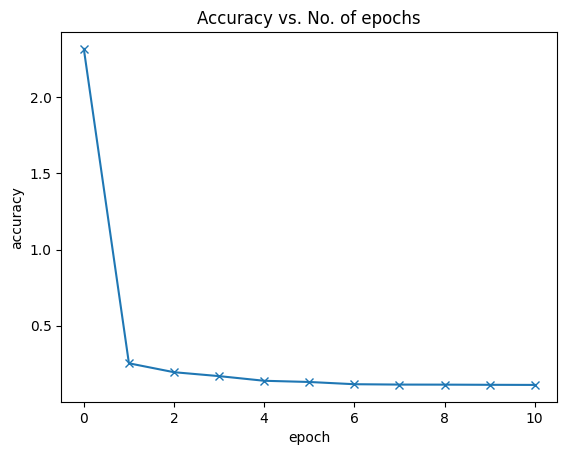

In [44]:
## Plot the losses and accuracies
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

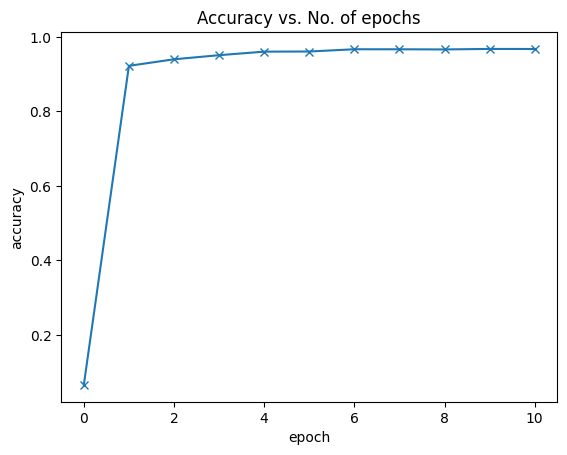

In [45]:


accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Testing with Individual images

In [47]:
## define test dataset
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [48]:
## Helper function to predict image
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 , Predicted: 7


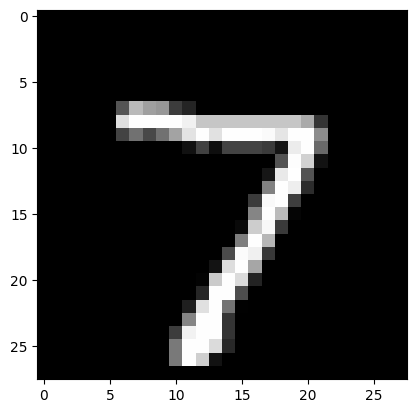

In [49]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


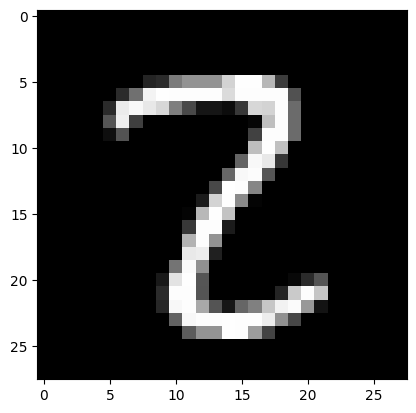

In [50]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


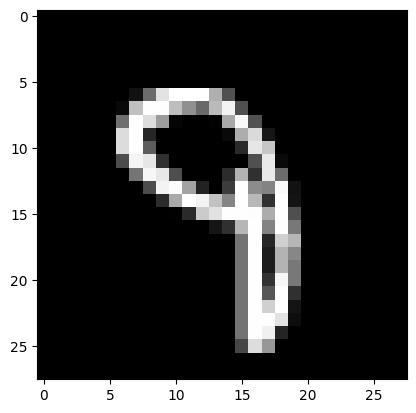

In [51]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 5 , Predicted: 5


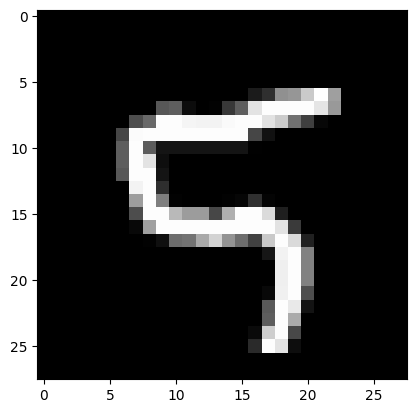

In [53]:
img, label = test_dataset[791]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [54]:
## overall loss and accuracy on test set
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10278649628162384, 'val_acc': 0.9681640863418579}